In [ ]:
# install transformer
!pip install transformers

In [ ]:
import re
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Train data
train_df= pd.read_csv("/content/drive/MyDrive/Research NLP/research_data/sent_train.csv")
train_df.head(5)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [ ]:
# Validate data
validate_df= pd.read_csv("/content/drive/MyDrive/Research NLP/research_data/sent_valid.csv")
validate_df.head(5)

,text,label
0,$ALLY - Ally Financial pulls outlook https://t...,0
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0
2,$PRTY - Moody's turns negative on Party City h...,0
3,$SAN: Deutsche Bank cuts to Hold,0
4,$SITC: Compass Point cuts to Sell,0


In [ ]:
# Clean text column
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove special characters
    # text = re.sub(r"[^\w\s]", "", text)
    # Lowercasing
    text = text.lower()
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
validate_df['clean_text'] = validate_df['text'].apply(clean_text)

In [ ]:
train_df.head(5)

,text,label,clean_text
0,$BYND - JPMorgan reels in expectations on Beyo...,0,$bynd - jpmorgan reels in expectations on beyo...
1,$CCL $RCL - Nomura points to bookings weakness...,0,$ccl $rcl - nomura points to bookings weakness...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,"$cx - cemex cut at credit suisse, j.p. morgan ..."
3,$ESS: BTIG Research cuts to Neutral https://t....,0,$ess: btig research cuts to neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,$fnko - funko slides after piper jaffray pt cut


In [ ]:
validate_df.head(5)

,text,label,clean_text
0,$ALLY - Ally Financial pulls outlook https://t...,0,$ally - ally financial pulls outlook
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0,"$dell $hpe - dell, hpe targets trimmed on comp..."
2,$PRTY - Moody's turns negative on Party City h...,0,$prty - moody's turns negative on party city
3,$SAN: Deutsche Bank cuts to Hold,0,$san: deutsche bank cuts to hold
4,$SITC: Compass Point cuts to Sell,0,$sitc: compass point cuts to sell


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_dist_chart(df, run_mode):
    # Explore the distribution of classes
    # For train set
    train_class_distribution = Counter(df['label'])
    print("Class Distribution of train dataset:", train_class_distribution)

    # Convert the Counter object to a DataFrame for easier plotting
    class_dist_df = pd.DataFrame.from_dict(train_class_distribution, orient='index').reset_index()
    class_dist_df.columns = ['Class', 'Count']

    # Defining the plot size
    plt.figure(figsize=(5, 5))

    # Defining the values for x-axis, y-axis and creating the barplot
    plots = sns.barplot(x='Class', y='Count', data=class_dist_df)

    # Iterating over the bars one-by-one
    for bar in plots.patches:
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        plots.annotate(format(bar.get_height(), '.2f'),
                      (bar.get_x() + bar.get_width() / 2,
                       bar.get_height()), ha='center', va='center',
                      size=12, xytext=(0, 5),
                      textcoords='offset points')

    # Setting the title for the graph
    plt.title("{} data class-wise data count".format(run_mode))

    # Finally showing the plot
    plt.show()


Class Distribution of train dataset: Counter({2: 6178, 1: 1923, 0: 1442})


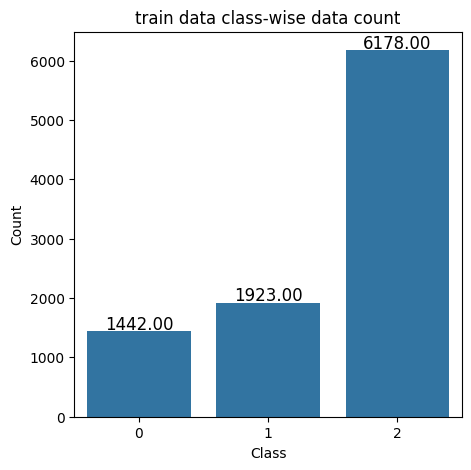

Class Distribution of train dataset: Counter({2: 1566, 1: 475, 0: 347})


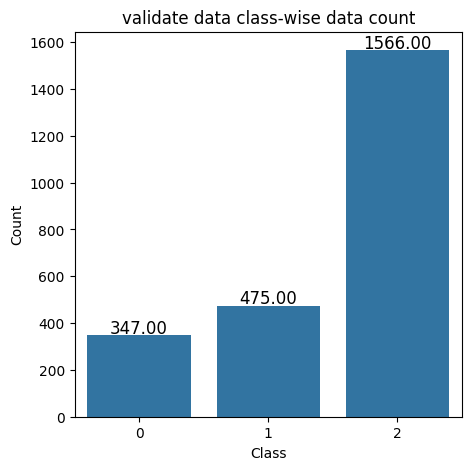

In [ ]:
# Clean text column
counter=0
for df in [train_df, validate_df]:
    if counter == 0:
        run_mode="train"
    else:
        run_mode="validate"
    plot_class_dist_chart(df, run_mode)
    counter+=1

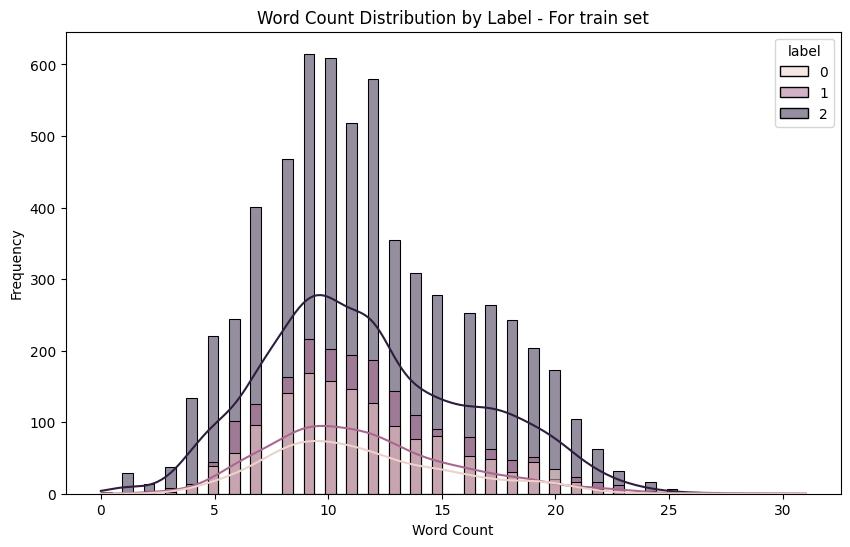

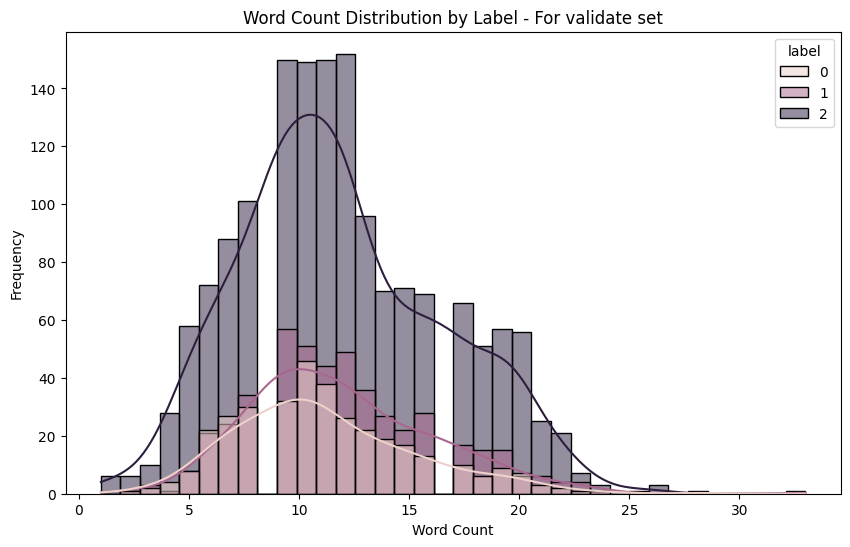

In [ ]:
# Perform text data analysis - Word count distribution
def word_count_distribution(df,run_mode):
    df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='word_count', hue='label', kde=True)
    plt.title('Word Count Distribution by Label - For {} set'.format(run_mode))
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()
# Calling word count distribution function
word_count_distribution(train_df,"train")
word_count_distribution(validate_df,"validate")

Wordcloud on train set


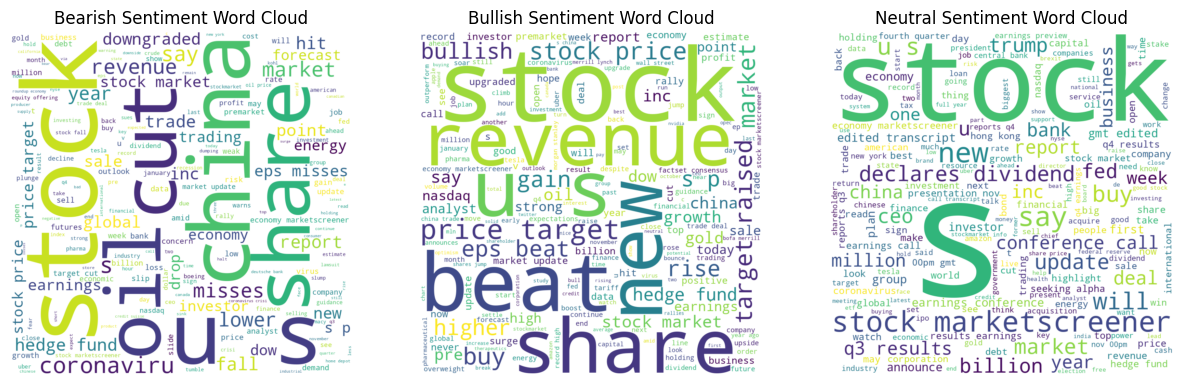

Wordcloud on validate set


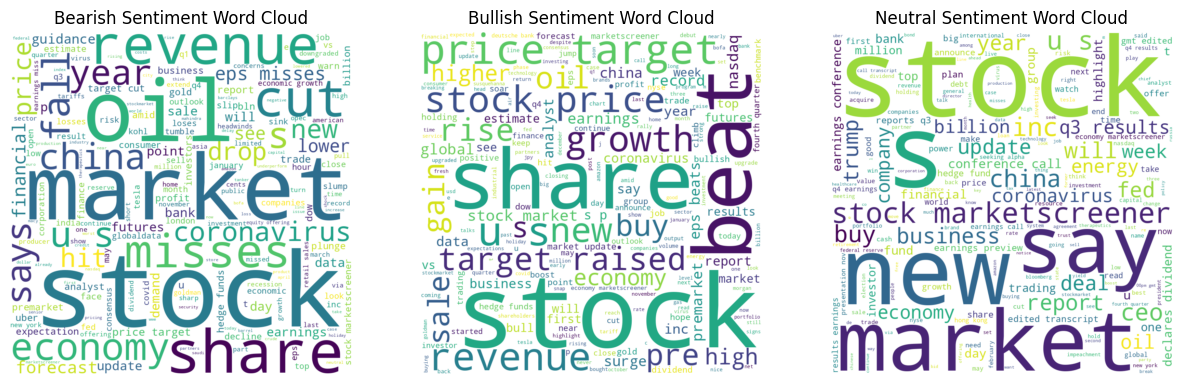

In [ ]:
# Creating wordcloud for train set for three sentiment labels - Bearish, Bullish and Neutral tweets
def generate_word_cloud(df):
    bearish_tweets = " ".join(df[df['label'] == 0]['clean_text'])
    bullish_tweets = " ".join(df[df['label'] == 1]['clean_text'])
    neutral_tweets = " ".join(df[df['label'] == 2]['clean_text'])

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(bearish_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Bearish Sentiment Word Cloud')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(bullish_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Bullish Sentiment Word Cloud')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(neutral_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Neutral Sentiment Word Cloud')
    plt.axis('off')

    plt.show()

# Generating wordclouds for train and validate datasets
counter=0
for df in [train_df,validate_df]:
    # setting title of plots
    if counter==0:
        print("Wordcloud on train set")
    else:
        print("Wordcloud on validate set")
    counter+=1
    generate_word_cloud(df)

In [ ]:
#  Treating class imbalance and using combination of both oversampler and undersampler
def handle_class_imbalance(df):
    oversampler = RandomOverSampler(sampling_strategy='auto')
    undersampler = RandomUnderSampler(sampling_strategy='auto')

    X = df['clean_text'].values.reshape(-1, 1)
    y = df['label']

    X_over, y_over = oversampler.fit_resample(X, y)
    X_balanced, y_balanced = undersampler.fit_resample(X_over, y_over)

    df_balanced = pd.DataFrame({'clean_text': X_balanced.flatten(), 'label': y_balanced})
    return df_balanced

In [ ]:
lst_df=[]
for df in [train_df, validate_df]:
    final_df = handle_class_imbalance(df)
    lst_df.append(final_df)

train_final_df = lst_df[0]
validate_final_df = lst_df[1]

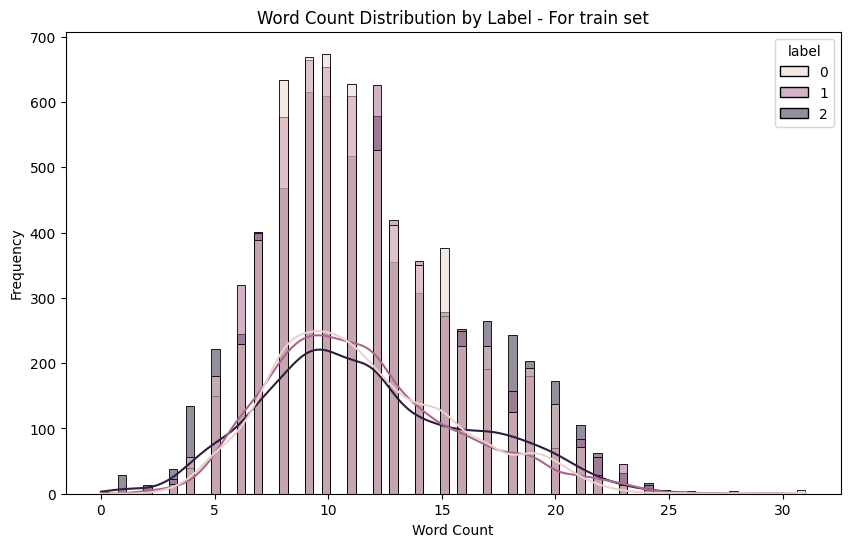

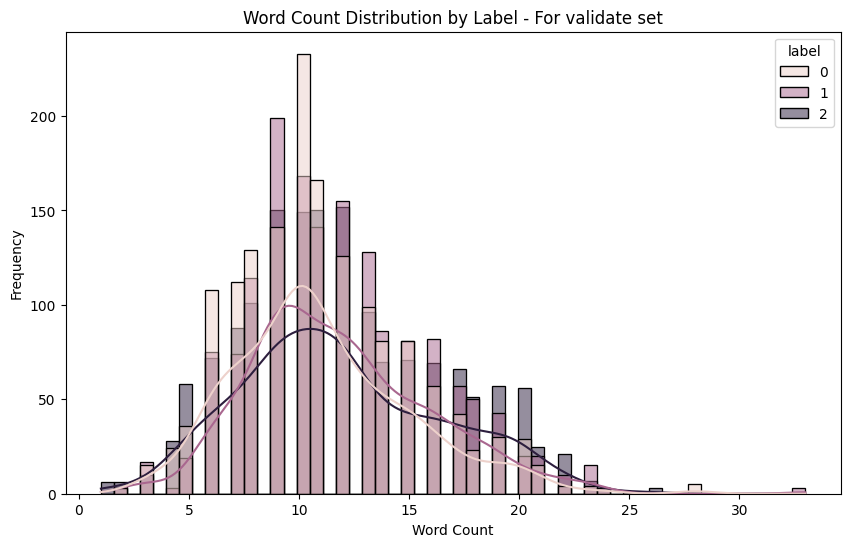

In [ ]:
# Perform text data analysis - Word count distribution
def word_count_distribution(df,run_mode):
    df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='word_count', hue='label', kde=True)
    plt.title('Word Count Distribution by Label - For {} set'.format(run_mode))
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()
# Calling word count distribution function
word_count_distribution(train_final_df,"train")
word_count_distribution(validate_final_df,"validate")

In [ ]:
train_final_df.head(5)

,clean_text,label,word_count
0,$bynd - jpmorgan reels in expectations on beyo...,0,9
1,$ccl $rcl - nomura points to bookings weakness...,0,13
2,"$cx - cemex cut at credit suisse, j.p. morgan ...",0,13
3,$ess: btig research cuts to neutral,0,6
4,$fnko - funko slides after piper jaffray pt cut,0,9


In [ ]:
validate_final_df.head(5)

,clean_text,label,word_count
0,$ally - ally financial pulls outlook,0,6
1,"$dell $hpe - dell, hpe targets trimmed on comp...",0,10
2,$prty - moody's turns negative on party city,0,8
3,$san: deutsche bank cuts to hold,0,6
4,$sitc: compass point cuts to sell,0,6


In [ ]:
X = list(train_final_df['clean_text'])
y = list(train_final_df['label'])

In [ ]:
# Split the data into training and validation sets
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
#from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# tested in transformers==4.18.0, pytorch==1.7.1
import torch
import transformers
torch.__version__, transformers.__version__

('2.3.0+cu121', '4.41.2')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Create FinBERT model
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/359 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
# Tokenize data
def tokenize_data(texts, labels):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,  # adjust this based on your data
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

train_input_ids, train_attention_masks, train_labels = tokenize_data(X_train, y_train)
test_input_ids, test_attention_masks, test_labels = tokenize_data(X_test, y_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Create TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # assuming 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Step 0/927 Loss 1.156395673751831
Epoch 1 Step 10/927 Loss 1.0038954019546509
Epoch 1 Step 20/927 Loss 0.9632705450057983
Epoch 1 Step 30/927 Loss 0.9229119420051575
Epoch 1 Step 40/927 Loss 0.70610511302948
Epoch 1 Step 50/927 Loss 0.540460467338562
Epoch 1 Step 60/927 Loss 0.8217141628265381
Epoch 1 Step 70/927 Loss 0.5739130973815918
Epoch 1 Step 80/927 Loss 0.8081497550010681
Epoch 1 Step 90/927 Loss 1.147438883781433
Epoch 1 Step 100/927 Loss 0.5840107202529907
Epoch 1 Step 110/927 Loss 0.40058863162994385
Epoch 1 Step 120/927 Loss 0.2740511894226074
Epoch 1 Step 130/927 Loss 0.5883586406707764
Epoch 1 Step 140/927 Loss 0.9513804912567139
Epoch 1 Step 150/927 Loss 0.7239162921905518
Epoch 1 Step 160/927 Loss 0.3245900869369507
Epoch 1 Step 170/927 Loss 0.7855247855186462
Epoch 1 Step 180/927 Loss 0.9731540083885193
Epoch 1 Step 190/927 Loss 0.6933552622795105
Epoch 1 Step 200/927 Loss 0.5335425138473511
Epoch 1 Step 210/927 Loss 0.34902632236480713
Epoch 1 Step 220/927 Los

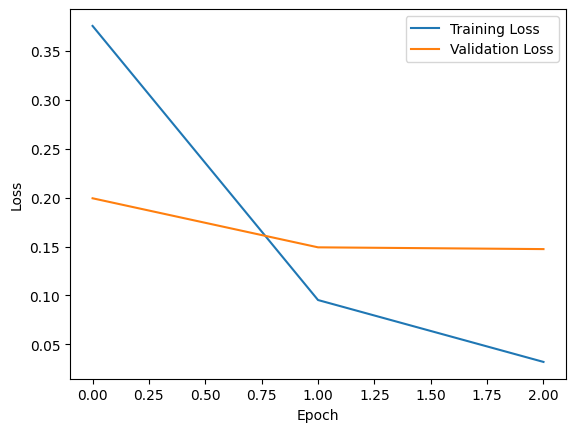

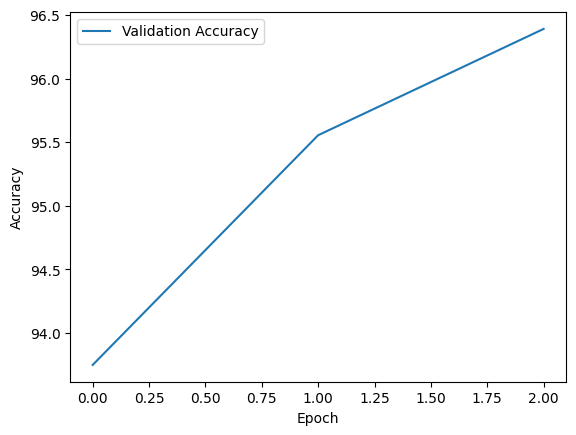

In [ ]:
# Early stopping parameters
patience = 2  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
model_save_path = 'FinBERT_w_class_imbalance'

# Training and evaluation loop
training_stats = []
for epoch in range(3):  # specify the number of epochs
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch_input_ids, batch_attention_masks, batch_labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 10 == 0:
            print(f"Epoch {epoch+1} Step {step}/{len(train_dataloader)} Loss {loss.item()}")

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation loop
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in test_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = batch
        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
        total_eval_accuracy += accuracy

    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    avg_val_loss = total_eval_loss / len(test_dataloader)
    print(f"Epoch {epoch+1} Validation Accuracy: {avg_val_accuracy}")
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss}")

    training_stats.append({
        'epoch': epoch + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
    })

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        print(f"Best model saved at epoch {epoch+1} with validation loss {avg_val_loss}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} with best validation loss {best_val_loss}")
            break

print("Training complete.")

# Load the best model for further evaluation or use
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

# Plot the training and validation loss
train_loss_values = [stat['Training Loss'] for stat in training_stats]
val_loss_values = [stat['Valid. Loss'] for stat in training_stats]

plt.plot(train_loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the validation accuracy
val_accuracy_values = [stat['Valid. Accur.'] for stat in training_stats]

plt.plot(val_accuracy_values, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Inference data

In [ ]:
# Drop word_count column
validate_final_df.drop(columns=['word_count'], inplace=True)

In [ ]:
validate_final_df.columns

Index(['clean_text', 'label'], dtype='object')

In [ ]:
# Tokenize the validation data
def tokenize_data(texts, labels):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,  # adjust this based on your data
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

# Tokenize the validation data
texts = validate_final_df['clean_text'].tolist()
labels = validate_final_df['label'].tolist()

validate_input_ids, validate_attention_masks, validate_labels = tokenize_data(texts, labels)

# Create DataLoader for the validation data
validate_dataset = TensorDataset(validate_input_ids, validate_attention_masks, validate_labels)
validate_dataloader = DataLoader(validate_dataset, batch_size=16, shuffle=False)

# Function to perform predictions
def predict(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = batch

        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

    return predictions, true_labels

# Perform predictions on the validation data
predictions, true_labels = predict(model, validate_dataloader)

# Display results
result_df = validate_final_df.copy()
result_df['predicted_label'] = predictions
print(result_df)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


                                             clean_text  label  \
0                 $ally - ally financial pulls outlook       0   
1     $dell $hpe - dell, hpe targets trimmed on comp...      0   
2         $prty - moody's turns negative on party city       0   
3                      $san: deutsche bank cuts to hold      0   
4                     $sitc: compass point cuts to sell      0   
...                                                 ...    ...   
4693  fed chairman jerome powell puts lawmakers on n...      2   
4694  semafo to restart mining at its boungou in q4;...      2   
4695  democrats are desperate to catch up with the t...      2   
4696  top economist lowers recession risk for 2020 b...      2   
4697  here is what hedge funds think about focus fin...      2   

      predicted_label  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
4693                2  
4694           

In [ ]:
import pandas as pd
# Save data to location
result_df.to_csv("/content/drive/MyDrive/Research NLP/Results/finbert_w_class_imbalance/finbert_w_class_imbalance.csv", index=False)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Extract actual and predicted labels
y_true = result_df['label']
y_pred = result_df['predicted_label']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Display metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8471690080885483
Precision: 0.8536307025330983
Recall: 0.8471690080885482
F1 Score: 0.8476688952795964
Confusion Matrix:
 [[1262   82  222]
 [  76 1302  188]
 [  82   68 1416]]


Interpretation of model results

1. Accuracy (0.8472):

  The accuracy of 84.7% indicates that the model correctly predicts the outcome for approximately 84.7% of the instances in the dataset. While this is a relatively strong performance, accuracy alone may not fully capture the nuances of the model's effectiveness, particularly if the dataset contains imbalanced classes or if the costs of different types of misclassification are unequal.
2. Precision (0.8536):

  Precision is measured at 85.4%, meaning that when the model predicts a positive class, it is correct 85.4% of the time. This suggests that the model is fairly proficient at reducing false positives, which is important in scenarios where the cost of incorrect positive predictions is significant.
3. Recall (0.8472):

  The recall value of 84.7% reflects the model’s ability to correctly identify positive cases from the actual positives in the dataset. This is crucial in situations where it’s important to minimize false negatives, ensuring that most relevant cases are captured.
4. F1 Score (0.8477):

  The F1 score, at 84.8%, represents a balanced measure of the model’s precision and recall. This metric is particularly valuable in cases where there is a need to balance the trade-off between precision and recall, offering a single metric that encapsulates both aspects of the model’s performance.
5. Confusion Matrix:

  The confusion matrix provides a detailed breakdown of how the model performs across different classes:
  Class 1: The model correctly classifies 1,262 instances as Class 1, but incorrectly classifies 82 as Class 2 and 222 as Class 3. This indicates that while Class 1 is generally well-identified, there is some overlap with Class 3.
  Class 2: There are 1,302 correct predictions for Class 2, but 76 instances are mistakenly identified as Class 1 and 188 as Class 3. The confusion between Classes 2 and 3 suggests that these classes may have some similar features, leading to misclassification.
  Class 3: The model correctly identifies 1,416 instances as Class 3, with 82 incorrectly labeled as Class 1 and 68 as Class 2. Class 3 shows the strongest performance with the fewest misclassifications, indicating that the model is most confident in predicting this class.
  Overall Summary:
    The model performs reasonably well with an overall accuracy of 84.7%, supported by solid precision and recall values. The F1 score, which balances these metrics, indicates that the model is fairly well-rounded in its ability to both identify and correctly classify instances. However, the confusion matrix reveals areas for improvement, particularly in distinguishing between Class 1 and Class 3, and Class 2 and Class 3, where some misclassifications occur. To enhance the model’s performance, particularly in these areas, further tuning or additional features might be necessary. This could involve refining the model's parameters or employing advanced techniques to better separate the classes, ultimately improving its reliability in real-world applications.